# Chi Square Test

**Goal:** Conduct and experiment to determine how long we need to run the experiment in order to detect a significant difference between control abd treatment groups, then run an experiment to evaluate the results using a chi-square test.

- Power calculation to determine the number of observations
- Use the cumulative density function to determine the experiment length. 
- Build a contigency table with the experiment results.
- Conduct a chi-square test to analyze the hypothesis. 


In [6]:
import math

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import plotly.express as px 
import scipy
from pymongo import MongoClient
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower

#### Calculate Power

- To get the meaningfull information - number of observations you need to include in the experiment.

In [11]:
chi_square_power = GofChisquarePower()
group_size = math.ceil(chi_square_power.solve_power(effect_size=0.2, alpha=0.05, power=0.8))

print("Group size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group size: 197
Total # of applicants needed: 394


- From the results, if we want to detect an effect size of 0.2 we need a group size of about 200 people.

 - Since our experiment has two conditions (treatment and control, or email and no email), that means we need a total of about 400 applicants in our experiment.

#### Power Curve Plot

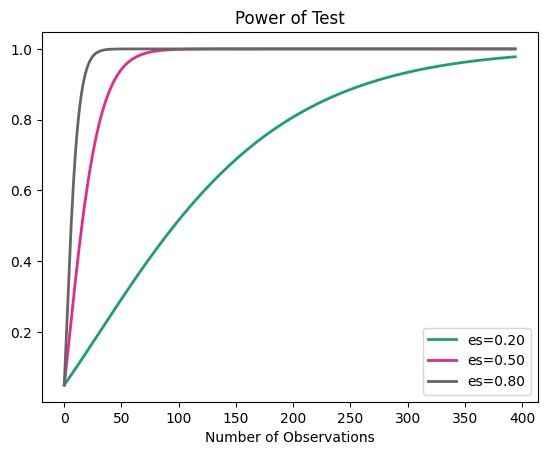

In [12]:
n_observations = np.arange(0, group_size * 2 + 1)
effect_sizes = np.array([0.2,.5,.8])
# Plot power curve using `chi_square_power`
chi_square_power.plot_power(
    dep_var="nobs",
    nobs=n_observations,
    effect_size=effect_sizes,
    alpha=.05,
    n_bins=2
);

- Green is the original size.
- Red is the median effect size.
- Gray is the large effect size.
- Large sizes have a power going to 1 - as we increase the number of observations, the experiment becomes more powerful.


### Calculate Subjects per Day

- From the above calculations, we need around 400 observations from this subset, but how long do we need to run our experiment for in order to get that number?

In [ ]:
result = ds_app.aggregate(
[
    {"$match":{"admissionsQuiz": "incomplete"}},
    {
        "$group": {
            "_id":{"$dateTrunc": {"date": "$createdAt", "unit": "day"}},
            "count": {"$sum": 1}
            
        }
    }
]
)

print("result type:", type(result))

Applicants Per Day to DataFrame

In [ ]:
no_quiz = (
    pd.DataFrame(result)
    .rename({"_id": "date", "count": "new_users"}, axis=1)
    .set_index("date")
    .sort_index()
    .squeeze()
)

print("no_quiz type:", type(no_quiz))
print("no_quiz shape:", no_quiz.shape)
no_quiz.head()

In [14]:
no_quiz=pd.read_csv("data/no_quiz.csv")
no_quiz.head()

,date,new_users
0,07/05/2022,46
1,23/05/2022,49
2,16/05/2022,38
3,09/05/2022,33
4,10/05/2022,41


In [15]:
no_quiz=no_quiz.set_index("date").sort_index().squeeze()

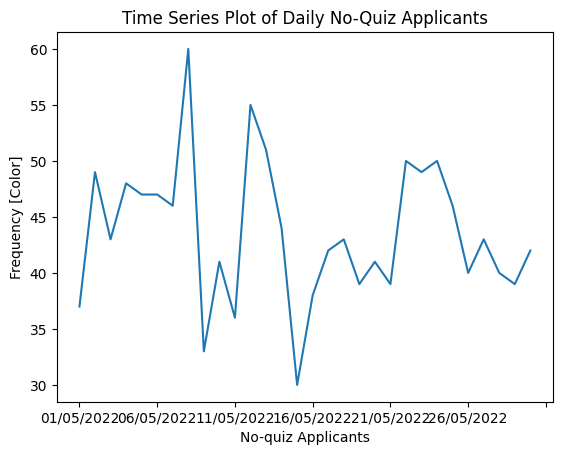

In [16]:
no_quiz.plot();
plt.xlabel("No-quiz Applicants")
plt.ylabel("Frequency [Color]")
plt.title("Time Series Plot of Daily No-Quiz Applicants");

Distribution of Applicants Per Day

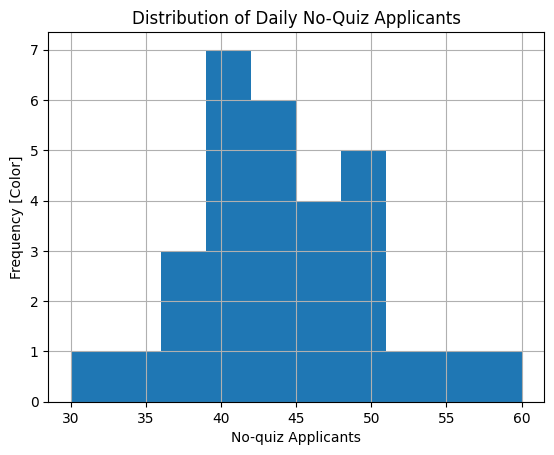

In [17]:
# Create histogram of `no_quiz`
no_quiz.hist();
# Add axis labels and title
plt.xlabel("No-quiz Applicants")
plt.ylabel("Frequency [Color]")
plt.title("Distribution of Daily No-Quiz Applicants");

 - We see that somewhere between 30–60 no-quiz applicants come to the site every day. But how can we use this information to ensure that we get our 400 observations? 

Applicants Per Day Summary Statistics

In [18]:
no_quiz.describe()["mean"]

43.6

In [19]:
mean = no_quiz.mean()
std = no_quiz.std()
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 43.6
no_quiz std: 6.398275629767974


- The distribution plot above shows how many no-quiz applicants come to the site each day, but we can use that mean and standard deviation to create a new distribution — one for the sum of no-quiz applicants over several day

10-Day probability Distribution

In [20]:
days = 10
sum_mean = mean * days
sum_std = std * math.sqrt(days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 436.0
Std of sum: 20.233124087615032


- With this new distribution, we want to know what the probability is that we'll have 400 or more no-quiz applicants after 10 days. We can calculate this using the cumulative density function or CDF

Cumulative Density Function

- Calculating the probability of getting 400 or more sign-ups over three days.

In [21]:
prob_400_or_fewer = scipy.stats.norm.cdf(
    group_size * 2,
    loc=sum_mean,
    scale=sum_std
)
prob_400_or_greater = 1 - prob_400_or_fewer 

print(
    f"Probability of getting 400+ no_quiz in {days} days:",
    round(prob_400_or_greater, 3),
)

Probability of getting 400+ no_quiz in 10 days: 0.981


- The results suggest that there should be around round a 98% chance that we'll get the number of applicants we need over 10 days.

### Running the Experiment

In [22]:
df=pd.read_csv("data/df.csv")

print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (416, 12)


,_id,createdAt,firstName,lastName,email,birthday,gender,highestDegreeEarned,countryISO2,admissionsQuiz,inExperiment,group
0,661e0aec196f9b2f2be9b9fb,17/04/2024 04:06,Harvey,Todd,harvey.todd74@yahow.com,10/07/1995,male,Master's degree,LK,complete,True,email (t)
1,661e0aec196f9b2f2be9ba07,18/04/2024 10:07,Joseph,Smith,joseph.smith46@yahow.com,24/01/1997,male,Bachelor's degree,MA,complete,True,email (t)
2,661e0aec196f9b2f2be9ba08,18/04/2024 03:40,Juanita,Moore,juanita.moore66@yahow.com,04/09/2003,female,High School or Baccalaureate,NG,complete,True,email (t)
3,661e0aec196f9b2f2be9ba0e,20/04/2024 04:16,David,Walsh,david.walsh21@microsift.com,20/02/1996,male,Master's degree,ET,complete,True,email (t)
4,661e0aec196f9b2f2be9ba0f,26/04/2024 04:35,Lester,Nathaniel,lester.nathaniel32@gmall.com,21/10/2001,male,Bachelor's degree,NG,complete,True,email (t)


### Build Contingency Table

- 1. Raw counts:

In [23]:
data = pd.crosstab(
    index=df["group"],
    columns=df["admissionsQuiz"],
    normalize=False
)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


admissionsQuiz,complete,incomplete
group,,
email (t),15,193
no email (c),11,197


- 2. Percentages:

In [24]:
data = pd.crosstab(
    index=df["group"],
    columns=df["admissionsQuiz"],
    normalize=True
)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


admissionsQuiz,complete,incomplete
group,,
email (t),0.036058,0.463942
no email (c),0.026442,0.473558


#### Results Bar Chart

In [25]:
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(
        data_frame=data,
        barmode="group",
        title="Admissions Quiz Completion by Group"
    )
    # Set axis labels
    fig.update_layout(
        xaxis_title ="Group",
        yaxis_title = "Frequency [count]",
        legend = {"title": "Admissions Quiz"}
    )
    return fig


build_contingency_bar().show()

- Observe that people who got an email actually did complete the quiz more often than people who didn't. So can we conclude that, as a general rule, applicants who receive an email are more likely to complete quiz.

#### Build Contigency Table

In [26]:
contingency_table = Table2x2(data.values)

print("contingency_table type:", type(contingency_table))
contingency_table.table_orig

contingency_table type: <class 'statsmodels.stats.contingency_tables.Table2x2'>


array([[0.03605769, 0.46394231],
       [0.02644231, 0.47355769]])

Contigency Table: Fitted Values

In [27]:
# Calculate fitted values
contingency_table.fittedvalues

array([[0.03125, 0.46875],
       [0.03125, 0.46875]])

Contingency Table: Independence Probabilities

In [28]:
# Calculate independent joint probabilities
contingency_table.independence_probabilities.round(3)

array([[0.031, 0.469],
       [0.031, 0.469]])

### Conduct Chi-Square Test

In [29]:
chi_square_test = contingency_table.test_nominal_association()

print("chi_square_test type:", type(chi_square_test))
print(chi_square_test)

chi_square_test type: <class 'statsmodels.stats.contingency_tables._Bunch'>
df          1
pvalue      0.9683140396481433
statistic   0.0015779092702169607


- The p-value is much higher than 0.05, which means that the difference we saw in our side-by-side bar graph is probably due to chance.

Odds Ratio

In [30]:
odds_ratio = contingency_table.oddsratio.round(1)
print("Odds ratio:", odds_ratio)

Odds ratio: 1.4


 - For every 1 person who doesn't complete the quiz, about 1.4 people do.

- However, this ratio isn't actionable in the case of our experiment because our results weren't statistically significant.

Chi-Square Summary

In [38]:
summary = contingency_table.summary()
print("summary type:", type(summary))
summarys

summary type: <class 'statsmodels.iolib.table.SimpleTable'>
